# *This notebook contains the code for the Coursera Capstone IBM Data Science Certificate*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [13]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_05e6e145e45a40a6868fc5018924ebc2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_05e6e145e45a40a6868fc5018924ebc2.get_object(Bucket='courseracapstone-donotdelete-pr-ksauy74m0lfpxv',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [14]:
df_data.info()
# further research into the columns which have significant missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

# Remove columns that are irrelevant

In [5]:
df_data['SPEEDING'].isnull().sum()/df_data.shape[0]
#95% of the rows in Speeding columns are NAN

0.9520580666039975

In [15]:
df_data = df_data.drop(['OBJECTID','INCKEY','LOCATION','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE',
              'EXCEPTRSNDESC','SEVERITYDESC','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE',
              'ST_COLDESC','SEGLANEKEY','CROSSWALKKEY'],axis=1)


In [16]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 21 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
ADDRTYPE          192747 non-null object
SEVERITYCODE.1    194673 non-null int64
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SPEEDING          9333 non-null object
HITPARKEDCAR      194673 non-null object
dtypes: float64(2), int64(6), object(

In [19]:
df_data['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [21]:
df_data['UNDERINFL'] = df_data['UNDERINFL'].replace(['0'], 'N')
df_data['UNDERINFL'] = df_data['UNDERINFL'].replace(['1'], 'Y')
df_data['UNDERINFL'].value_counts()


N    180668
Y      9121
Name: UNDERINFL, dtype: int64

In [22]:
# remove columns with large amount of missing data
df_data = df_data.drop(["INATTENTIONIND","PEDROWNOTGRNT"],axis=1)


In [23]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 19 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
ADDRTYPE          192747 non-null object
SEVERITYCODE.1    194673 non-null int64
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
SPEEDING          9333 non-null object
HITPARKEDCAR      194673 non-null object
dtypes: float64(2), int64(6), object(11)
memory usage: 28.2+ MB


In [24]:
df_data['SPEEDING'] = df_data['SPEEDING'].apply(lambda x: 1 if x=='Y' else 0)
df_data['SPEEDING'].isna().sum()

0

# Check to see if there is a pattern of more accidents depending on the day of the week

In [25]:
analysis = df_data.copy()
analysis['day_of_week'] = pd.DatetimeIndex(analysis['INCDATE']).weekday_name
analysis['day_of_week'].value_counts(normalize=True)


Friday       0.166089
Thursday     0.150632
Wednesday    0.147827
Tuesday      0.146687
Saturday     0.140692
Monday       0.135294
Sunday       0.112779
Name: day_of_week, dtype: float64

# Check data for daily monthly and yearly patterns using the copy

In [26]:
analysis['month'] = pd.DatetimeIndex(analysis['INCDATE']).month
analysis['year'] = pd.DatetimeIndex(analysis['INCDATE']).year
analysis.head()

,SEVERITYCODE,X,Y,ADDRTYPE,SEVERITYCODE.1,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR,day_of_week,month,year
0,2,-122.323148,47.703140,Intersection,2,Angles,2,0,0,2,...,At Intersection (intersection related),N,Overcast,Wet,Daylight,0,N,Wednesday,3,2013
1,1,-122.347294,47.647172,Block,1,Sideswipe,2,0,0,2,...,Mid-Block (not related to intersection),N,Raining,Wet,Dark - Street Lights On,0,N,Wednesday,12,2006
2,1,-122.334540,47.607871,Block,1,Parked Car,4,0,0,3,...,Mid-Block (not related to intersection),N,Overcast,Dry,Daylight,0,N,Thursday,11,2004
3,1,-122.334803,47.604803,Block,1,Other,3,0,0,3,...,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,0,N,Friday,3,2013
4,2,-122.306426,47.545739,Intersection,2,Angles,2,0,0,2,...,At Intersection (intersection related),N,Raining,Wet,Daylight,0,N,Wednesday,1,2004


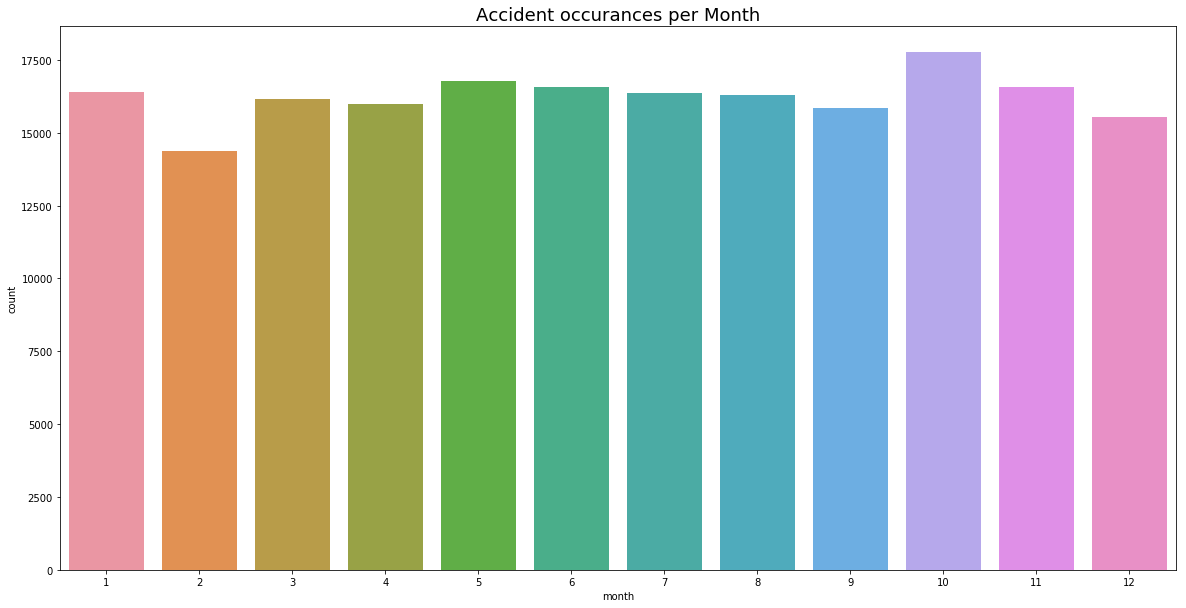

In [27]:
plt.figure(figsize=(20,10))
sns.countplot(x='month', data = analysis)
plt.title('Accident occurances per Month', fontsize=18)
sns.set(style="darkgrid")


Text(0.5, 1.0, 'Accident occurances per Year')

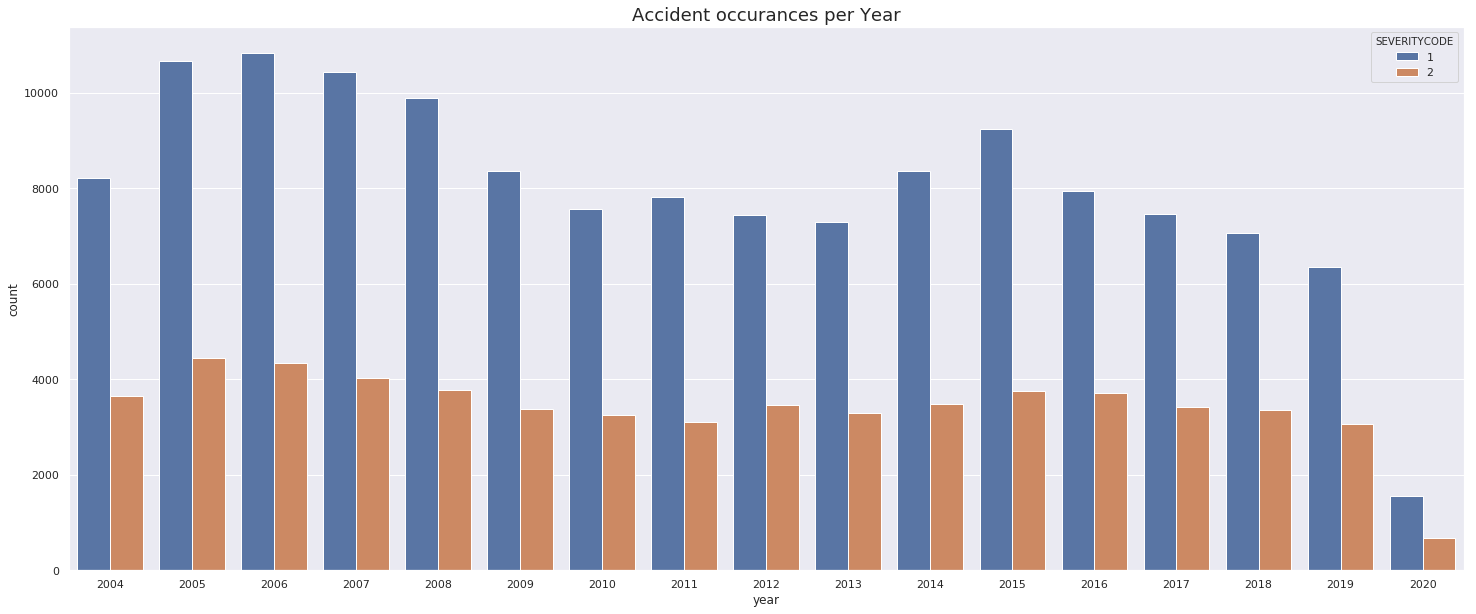

In [28]:
plt.figure(figsize=(25,10))
monthly_accident = sns.countplot(x='year', data = analysis, hue='SEVERITYCODE')
plt.title('Accident occurances per Year', fontsize=18)

Text(0.5, 1.0, 'Accident occurances per Year')

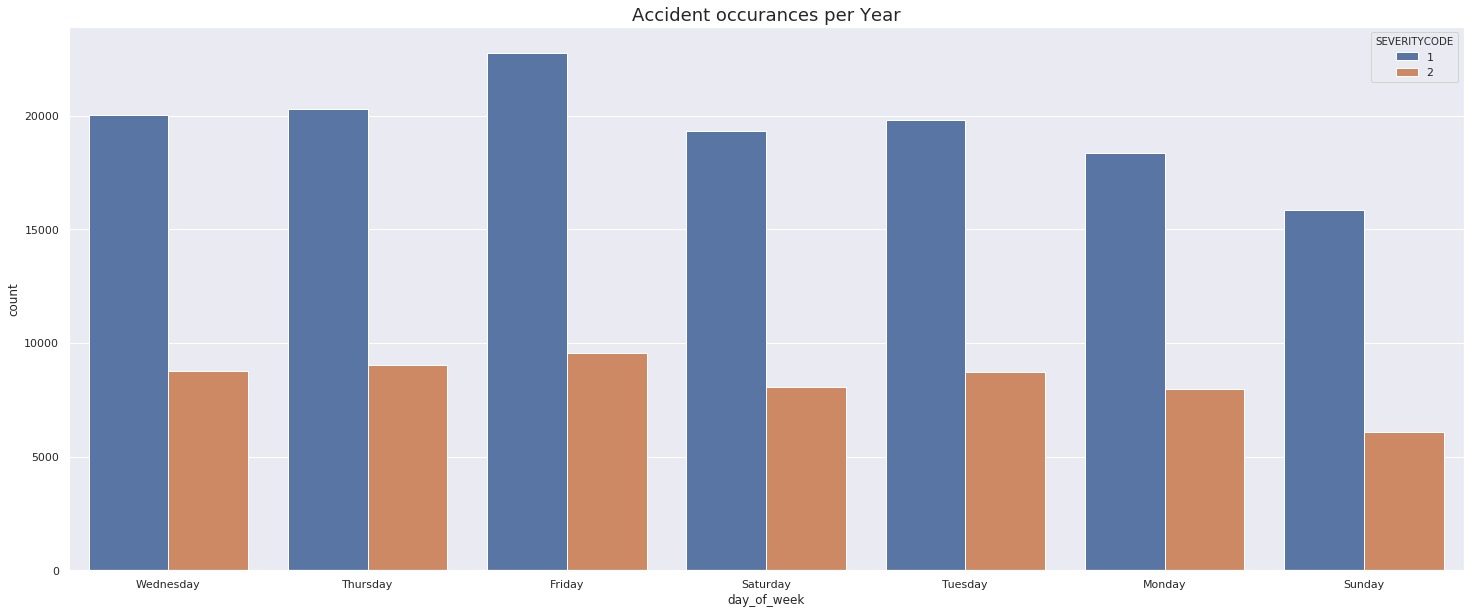

In [29]:
plt.figure(figsize=(25,10))
monthly_accident = sns.countplot(x='day_of_week', data = analysis, hue ='SEVERITYCODE')
plt.title('Accident occurances per Year', fontsize=18)

# Check correlations

SEVERITYCODE        int64
X                 float64
Y                 float64
ADDRTYPE           object
SEVERITYCODE.1      int64
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
SPEEDING            int64
HITPARKEDCAR       object
dtype: object

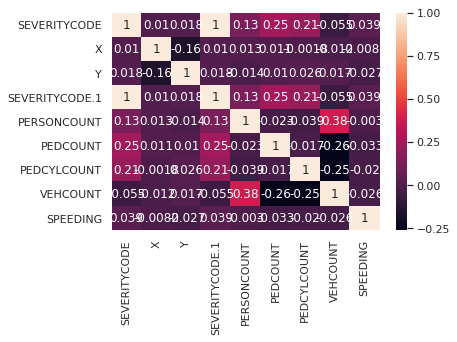

In [30]:
sns.heatmap(df_data.corr(), annot = True)
df_data.dtypes

# Check for unbalanced data in the target

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64


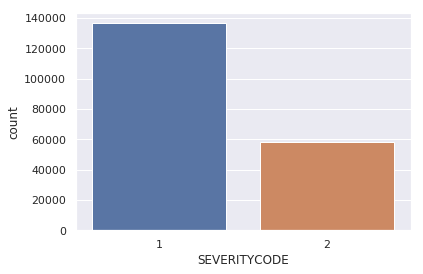

In [32]:
print(df_data['SEVERITYCODE'].value_counts())
sns.countplot(x='SEVERITYCODE', data = df_data)

* Approximately 70% of the target is Severity code one. Will need to balance the data


In [34]:
#shuffling and creating a balanced dataset
df_data= df_data.sample(frac=1,random_state=0,replace=False)

# 1 - Put all severity code 2 class in a separate dataset.
df_scode2 = df_data.loc[df_data['SEVERITYCODE'] == 2]

# 2 - Randomly select 58188 observations from the severity code 1(majority class)
df_scode1 = df_data.loc[df_data['SEVERITYCODE'] == 1].sample(n=58188,random_state=42)

# 3 - concatenating datasets to get balanced dataset
df_balanced = pd.concat([df_scode1,df_scode2])
df_balanced = df_balanced.sample(frac=1,random_state=0,replace=False)


#checking if dataset balanced
print(df_balanced.info())
print(df_balanced['SEVERITYCODE'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116376 entries, 142201 to 144777
Data columns (total 19 columns):
SEVERITYCODE      116376 non-null int64
X                 113500 non-null float64
Y                 113500 non-null float64
ADDRTYPE          115474 non-null object
SEVERITYCODE.1    116376 non-null int64
COLLISIONTYPE     113716 non-null object
PERSONCOUNT       116376 non-null int64
PEDCOUNT          116376 non-null int64
PEDCYLCOUNT       116376 non-null int64
VEHCOUNT          116376 non-null int64
INCDATE           116376 non-null object
INCDTTM           116376 non-null object
JUNCTIONTYPE      113453 non-null object
UNDERINFL         113733 non-null object
WEATHER           113609 non-null object
ROADCOND          113660 non-null object
LIGHTCOND         113569 non-null object
SPEEDING          116376 non-null int64
HITPARKEDCAR      116376 non-null object
dtypes: float64(2), int64(7), object(10)
memory usage: 17.8+ MB
None
2    58188
1    58188
Name: SEVERITYCODE,